
# Float vertical position control, ifremer prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [17]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

from matplotlib import cm

WOA water profile at lon=-50, lat=40


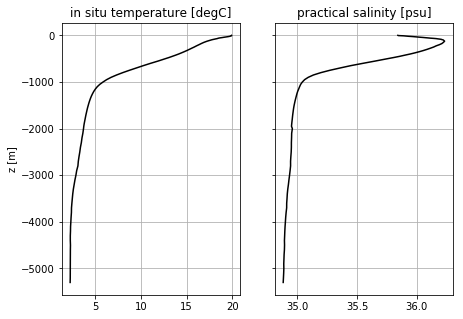

In [18]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [19]:
# Init now active control of the vertical position

#
z=np.arange(-5000.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='IFREMER')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .90

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

1439.4 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 13.07 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte     = 1.03e+09 kg.cm^3   - float constant density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 9.75 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 127.93 cm^3      - present volume addition
  lead  = 100.00 cm        - screw lead
  d_increment  = 0.00 m        - smallest variation of

In [20]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

9.93960815039054
-11.72099235900805


In [21]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
#f.piston.update_d(f.piston.d+.001)
#f.piston_update_vol()
#print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=7.0e-01 cm^3  
z equilibrium = -20.0m


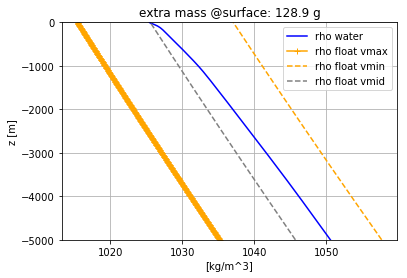

In [22]:
# show densities
plot_float_density(z, f, w, mid=vstart)

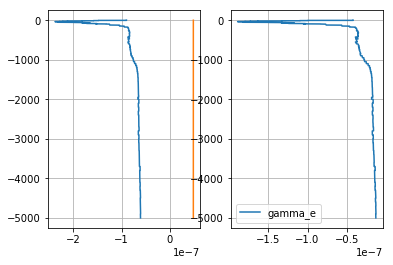

In [23]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

---

## From the surface down to a target level

In [24]:
# we start by constructing a trajectory that can be followed by the float
z_target_variable = descent(3600, -25., f, w, zstart = -p_eq)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=9.7e-02 m^2/s, fmin/m= -9.2e-02 m^2/s, wmax= 522.9 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 5.8e+02 cm/s, fmin/m= -5.5e+02 cm/s


In [25]:
# we start by constructing a trajectory that can be followed by the float
z_target_regular = lambda t:-25

In [26]:
def plot_kalman(f):
    
    fig = plt.figure(figsize=(15,10))
    #
    ax=fig.add_subplot(231)
    ax.plot(f.log.t,f.log.z,'-', label = "real depth")
    ax.plot(f.t_kalman[1:],-f.log.z_kalman, label ="estimated depth")
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(232)
    ax.plot(f.log.t,f.log.w, label = "real velocity")
    ax.plot(f.t_kalman[1:],-f.log.w_kalman, label ="estimated velocity")
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(233)
    ax.plot(f.log.t,f.log.gammaV, label = "float compressibility x float volume")
    ax.plot(f.t_kalman[1:],f.log.gammaE_kalman, label ="estimated equivalent compressibility")
    ax.set_title("equivalent compressibility as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("gammaE (m^2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(234)
    ax.plot(f.log.t,f.log.Ve*1e6, label = "real Ve volume")
    ax.plot(f.t_kalman[1:],f.log.Ve_kalman*1e6, label ="estimated Ve volume")
    ax.set_title("volume Ve as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("Ve (cm^3)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')   
    #
    ax=fig.add_subplot(235)
    ax.plot(f.log.t,-f.log.dwdt, label = "real acceleration")
    ax.plot(f.t_kalman[1:],f.log.dwdt_kalman, label ="estimated acceleration")
    ax.set_title("acceleration dw/dt as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("dw/dt (m.s^-2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 


    def plot_regulation(f, vmax, nu, tau, delta):
        fig = plt.figure(figsize=(10,5))
        #
        ax=fig.add_subplot(121)
        ax.plot(f.log.t,f.log.z,'-', label = "depth")
        ax.set_title("depth as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
        ax.set_xlabel("t (s)")
        ax.set_ylabel("z (m)")
        ax.grid()
        #
        ax=fig.add_subplot(122)
        ax.plot(f.log.t,f.log.w, label = "velocity")
        ax.set_title("velocity as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
        ax.set_xlabel("t (s)")
        ax.set_ylabel("w (m/s)")
        ax.grid()
        # 
        
def plot_depth(ax,f, vmax, nu, tau, delta, target, ref=False):

    if ref:
        ax.plot(f.log.t,f.log.z, label = "ref :: vmax:%.2f m/s, \u03C4:%.3f s, \u03B4:%.3f m"%(vmax,tau,delta),
               c = 'black', ls = '--')
    else:
        ax.plot(f.log.t,f.log.z, label = "vmax:%.2f m/s, \u03C4:%.3f s, \u03B4:%.3f m"%(vmax,tau,delta))
    ax.set_title("depth as a function of time for "+target)
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    #

def plot_velocity(ax,f, vmax, nu, tau, delta, target, ref=False):

    if ref:
        ax.plot(f.log.t,f.log.w, label = "ref :: vmax:%.2f m/s, \u03C4:%.3f s, \u03B4:%.3f m"%(vmax,tau,delta),
        c = 'black', ls = '--')
    else:
        ax.plot(f.log.t,f.log.w, label = "vmax:%.2f m/s, \u03C4:%.3f s, \u03B4:%.3f m"%(vmax,tau,delta))
    ax.set_title("velocity as a function of time for "+target)
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    #

---

## Parameter estimation functions for feedback regulation

In [27]:
#Functions and parameters necesary to estimate parameters for feedback regulation

'''
parameters:
    g : gravity acceleration [m.s^-2]
    m : float mass [kg]
    a : float added mass [no dimension]
    r : float radius [m]
    L : float length [m]
    rho_w : water density [kg.m^3]
    omega :  current rotation rate [rad/s]
    lead : screw lead (i.e. displacement after one screw revolution) [m]
    r_piston : piston radius [m]
    u : piston flow [m^3.s^-1]
    translation_max : maximum translation speed for the piston [m.s^-1]
'''

params_ensta = {'r': 0.06, 'L': 0.5, 'a': 1., 'omega' : 20/48*2.*np.pi, 'lead' : 0.00175, 'r_piston' : 0.025}
params_ensta['m'] = 9.0 #1000. * np.pi * params_ensta['r'] ** 2 * params_ensta['L']

params_ensta['u'] = omega2dvdt(params_ensta['omega'], params_ensta['lead'], params_ensta['r_piston'])



params_ifremer = {'r': 0.07, 'L': 0.8278, 'a': 1., 'translation_max': 0.12/5600*225, 'lead' : 1.0, 'r_piston' : 0.0195/2}
params_ifremer['m'] = 11.630 #1000. * np.pi * params_ifremer['r'] ** 2 * params_ifremer['L']

params_ifremer['omega'] = params_ifremer['translation_max']*2.*np.pi/params_ifremer['lead']

params_ifremer['u'] = omega2dvdt(params_ifremer['omega'], params_ifremer['lead'], params_ifremer['r_piston'])

---

## Feedback regulation without Kalman filter
### Regulation parameters : nu variable, tau and delta fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.006366197723675814
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.817347557011209e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.0445633840657307
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816905148765088e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.12732395447351627
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8

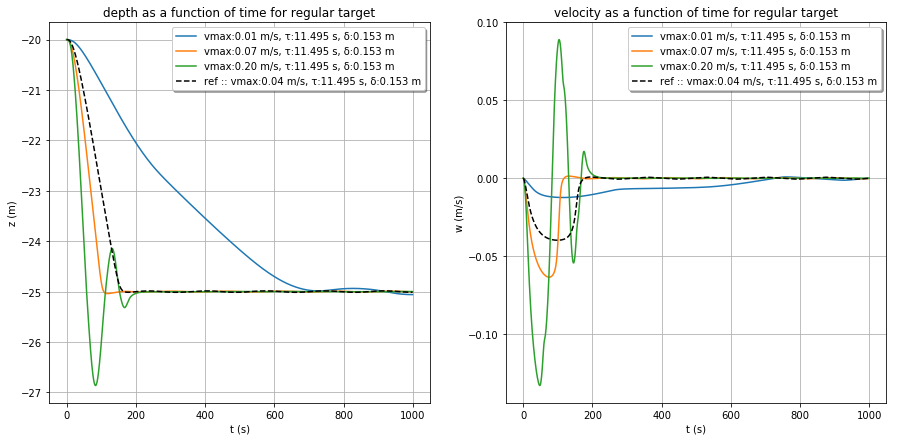

In [12]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}

z_target = z_target_regular

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_vmax = [0.01,0.07,0.20] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]
tab_tau = [tau_ref for i in range(len(tab_vmax))] #tv(vmax_reached, params_ensta)
tab_delta = [delta_ref for i in range(len(tab_vmax))] #zv(vmax_reached, params_ensta)


#colors = plt.cm.jet(np.linspace(0,1,len(tab_vmax)))


control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'nu':tab_nu[i]})
    #
    f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i],"regular target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i],"regular target")

control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)
ax1.grid()
ax2.grid()

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.006366197723675814
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816903154607334e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.0445633840657307
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.8169010250772167e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.12732395447351627
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.

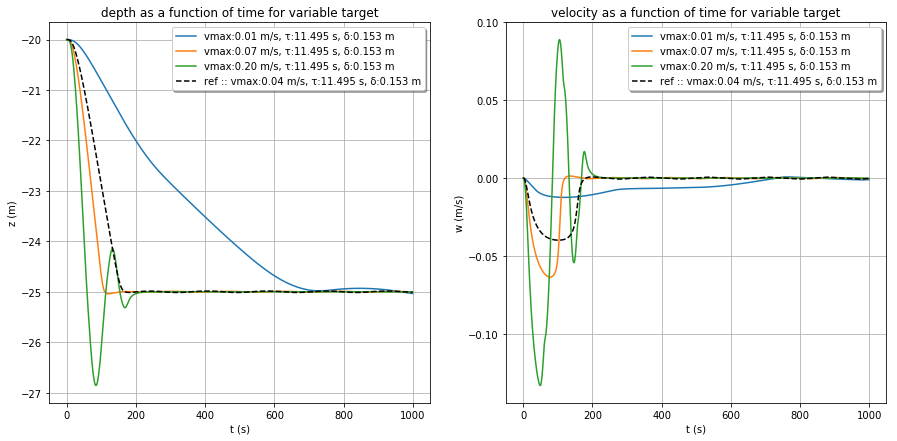

In [13]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}

z_target = z_target_variable

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_vmax = [0.01,0.07,0.20] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]
tab_tau = [tau_ref for i in range(len(tab_vmax))] #tv(vmax_reached, params_ensta)
tab_delta = [delta_ref for i in range(len(tab_vmax))] #zv(vmax_reached, params_ensta)


#colors = plt.cm.jet(np.linspace(0,1,len(tab_vmax)))


control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'nu':tab_nu[i]})
    #
    f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i],"variable target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i],"variable target")

control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)
ax1.grid()
ax2.grid()

---

### Regulation parameters : tau variable, nu and delta fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 0.01
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.8169040877791154e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.813345087374111e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 10.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.06943

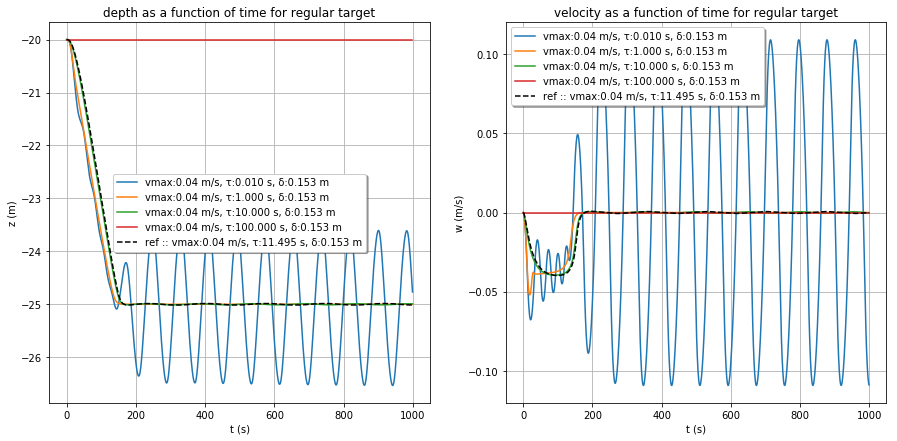

In [14]:
z_target = z_target_regular

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_tau = [0.01, 1.0, 10.0, 100.0] #tv(vmax_reached, params_ensta)
tab_vmax = [vmax_ref for i in range(len(tab_tau))] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]
tab_delta = [delta_ref for i in range(len(tab_tau))] #zv(vmax_reached, params_ensta)

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'tau':tab_tau[i]})
    #
    f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "regular target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "regular target")
    
    
control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 0.01
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.8169031481461666e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.8132908538675376e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 16 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 10.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.0694

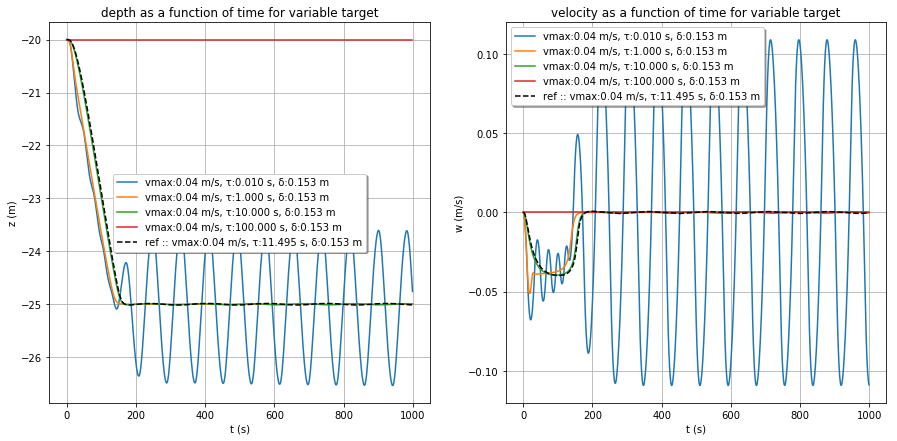

In [15]:
z_target = z_target_variable

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_tau = [0.01, 1.0, 10.0, 100.0] #tv(vmax_reached, params_ensta)
tab_vmax = [vmax_ref for i in range(len(tab_tau))] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]
tab_delta = [delta_ref for i in range(len(tab_tau))] #zv(vmax_reached, params_ensta)

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'tau':tab_tau[i]})
    #
    f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "variable target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "variable target")
    
    
control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)

---

### Regulation parameters : delta variable, nu and tau fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.001
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816904083868681e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.2
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.8154070006826276e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 1.0
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.06943302

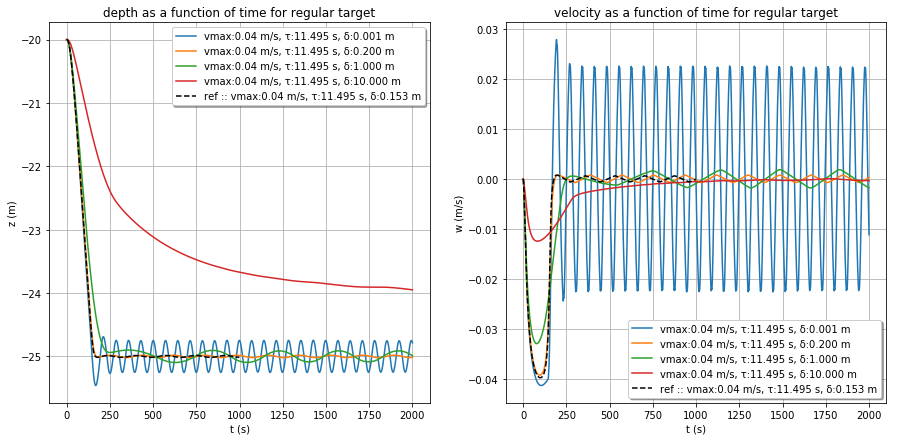

In [16]:
z_target = z_target_regular

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_delta = [0.001, 0.2, 1.0 , 10.0] #zv(vmax_reached, params_ensta)
tab_tau = [tau_ref for i in range(len(tab_delta))] #tv(vmax_reached, params_ensta)
tab_vmax = [vmax_ref for i in range(len(tab_delta))] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'delta':tab_delta[i]})
    #
    f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "regular target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "regular target")
    
    
control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.001
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816903148210613e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.2
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.81537029437834e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 1.0
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.0694330299

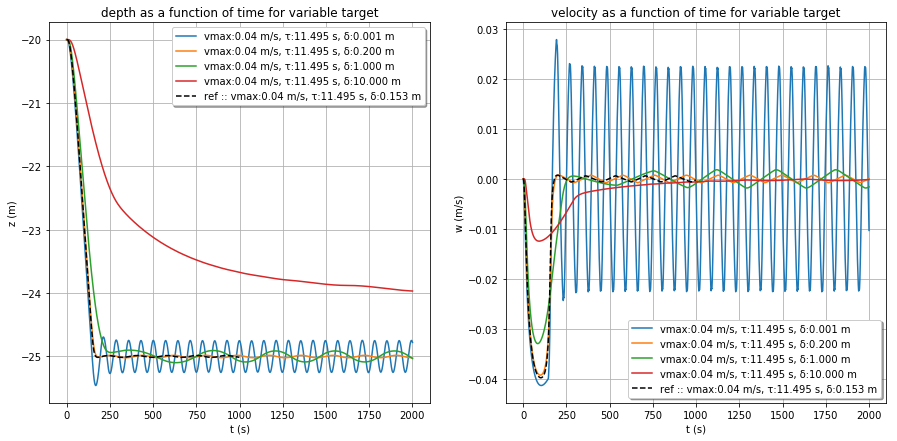

In [17]:
z_target = z_target_variable

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_delta = [0.001, 0.2, 1.0 , 10.0] #zv(vmax_reached, params_ensta)
tab_tau = [tau_ref for i in range(len(tab_delta))] #tv(vmax_reached, params_ensta)
tab_vmax = [vmax_ref for i in range(len(tab_delta))] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'delta':tab_delta[i]})
    #
    f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "variable target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "variable target")
    
    
control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=1000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)

---

### Regulation parameters : best case for vmax = 0.04 m/s

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.01
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.8169040611682294e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 5 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816890923567555e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 5 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m

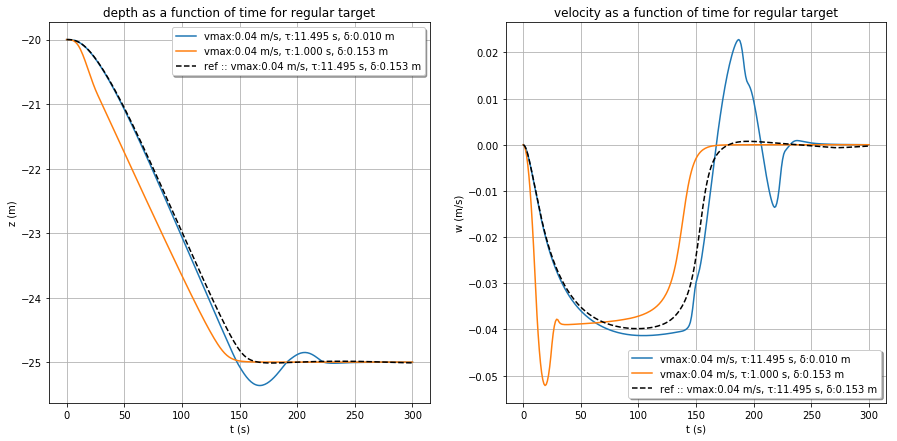

In [18]:
z_target = z_target_regular

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_vmax = [0.04,0.04] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_delta = [0.01, zv(vmax_ref, params_ifremer)]
tab_tau = [tv(vmax_ref, params_ifremer), 1.0]
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'tau':tab_tau[i], 'nu':tab_nu[i], 'delta':tab_delta[i]})
    #
    f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "regular target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "regular target")
    

control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"regular target", ref=True)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.01
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816903251484969e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 5 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m = 13.069433029960207
 ctrl: gammaV = 4.816888035460781e-08
 ctrl: rho = 912.6585777688305
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 5 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 11.494771571486668
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15326362095315563
 ctrl: gamma = 3.78039e-06
 ctrl: L = 0.8278
 ctrl: c1 = 1.0
 ctrl: m 

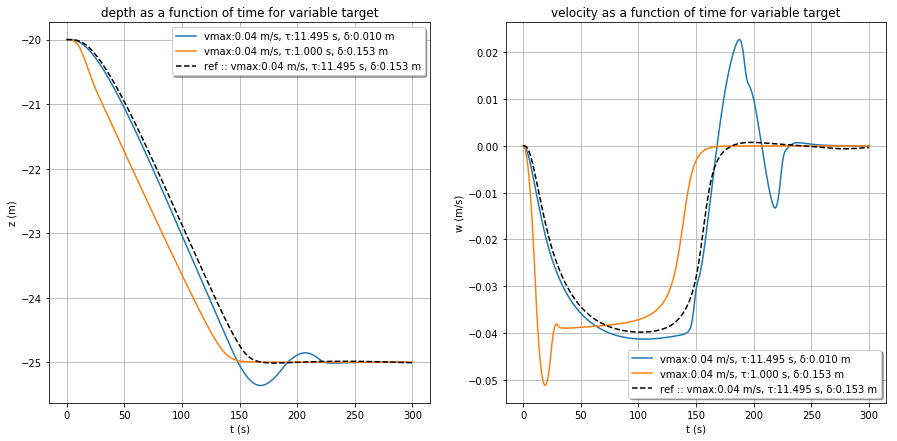

In [19]:
z_target = z_target_variable

vmax_ref = 0.04
delta_ref = zv(vmax_ref, params_ifremer)
tau_ref = tv(vmax_ref, params_ifremer)
nu_ref = (2/np.pi)*vmax_ref

tab_vmax = [0.04,0.04] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_delta = [0.01, zv(vmax_ref, params_ifremer)]
tab_tau = [tv(vmax_ref, params_ifremer), 1.0]
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(15,7))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'tau':tab_tau[i], 'nu':tab_nu[i], 'delta':tab_delta[i]})
    #
    f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "variable target")
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i], "variable target")
    

control.update({'tau':tau_ref,'nu':nu_ref,'delta':delta_ref})
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
            usepiston=True, z_target=z_target, ctrl=control, kalman=None, verbose=0)
plot_depth(ax1, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)
plot_velocity(ax2, f, vmax_ref, nu_ref, tau_ref, delta_ref,"variable target", ref=True)
#

---

## Feedback regulation with Kalman filter
### Kalman filter parameters : test

In [28]:
import copy
f0 = copy.deepcopy(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7f0bdeeb2e48>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


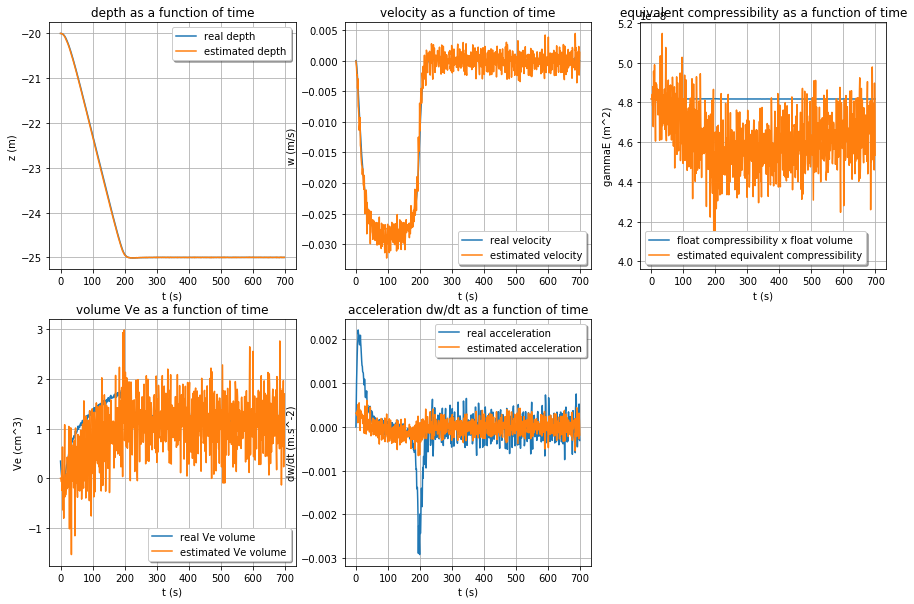

In [43]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}

f = copy.deepcopy(f0)

z_target = z_target_regular

vmax_reached = 0.03 #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
nu = (2/np.pi)*vmax_reached
tau = tv(vmax_reached, params_ifremer)
delta = zv(vmax_reached, params_ifremer)

control = {'tau': tau, 'dz_nochattering': 0., 'mode': 'kalman_feedback', 'nu': nu, 'delta': delta}
#
#
dt = 1. #s
depth_rms = 1e-3 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-6
t2V = f.piston.vol_error  #vol_error = 7.e-08
gamma_alpha_gammaE = 1e-8
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'vol_error': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])}
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

---

## Feedback regulation with Kalman filter
### Kalman filter parameters : Ve_rms variable

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f593c390>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


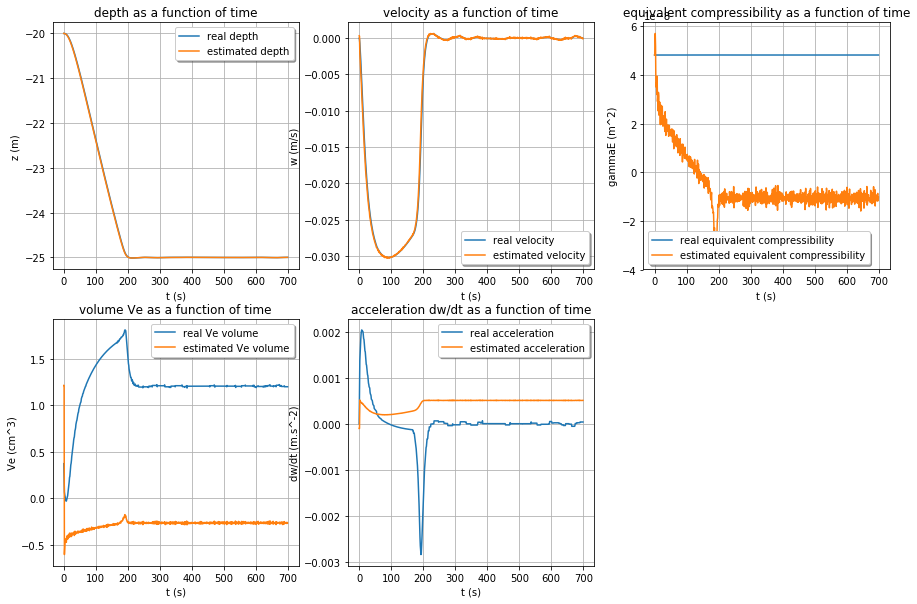

In [20]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}

z_target = z_target_regular

vmax_reached = 0.03 #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
nu = (2/np.pi)*vmax_reached
tau = tv(vmax_reached, params_ifremer)
delta = zv(vmax_reached, params_ifremer)

control = {'tau': tau, 'dz_nochattering': 0., 'mode': 'kalman_feedback', 'nu': nu, 'delta': delta}
#
#
dt = 1. #s
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-7
t2V = f.piston.vol_error  #vol_error = 7.e-08
gamma_alpha_gammaE = 1e-8
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'vol_error': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])}
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f75cf710>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


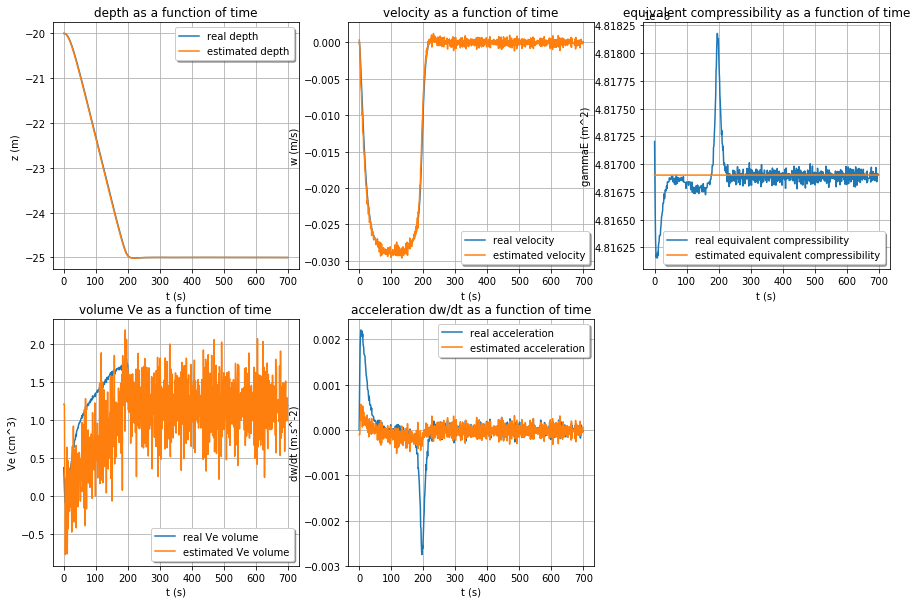

In [24]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



Ve_rms = 1e-3

kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] )})
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

---

### Kalman filter parameters : depth_rms variable

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f53649e8>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


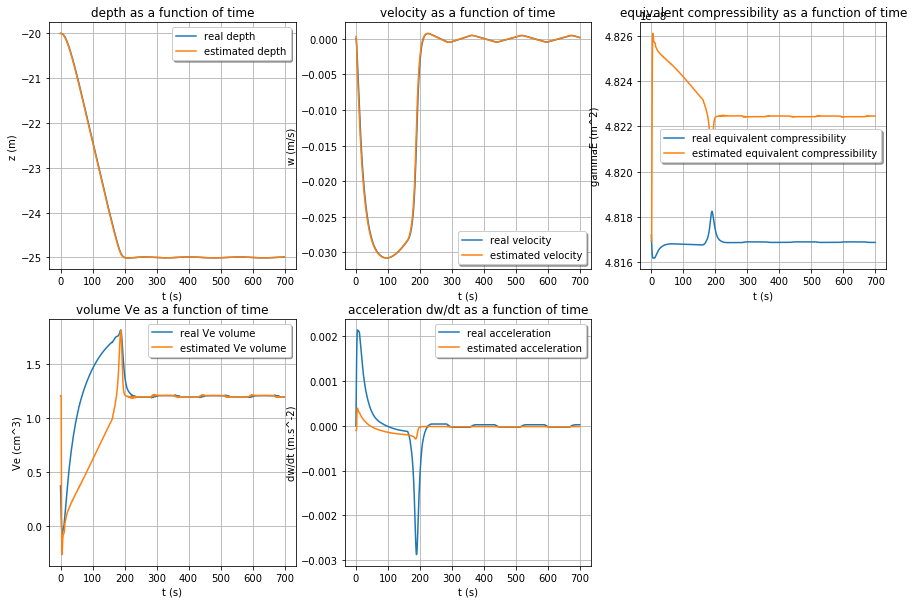

In [25]:
depth_rms = 1e-7 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f7501e48>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


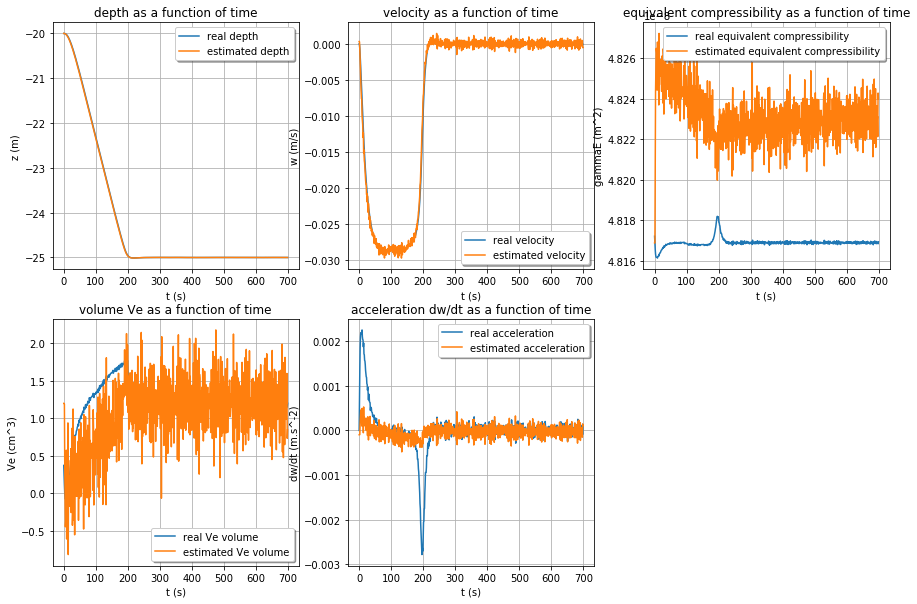

In [26]:
depth_rms = 1e-4 # m
vel_rms = depth_rms/dt # mm/s
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f592c3c8>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


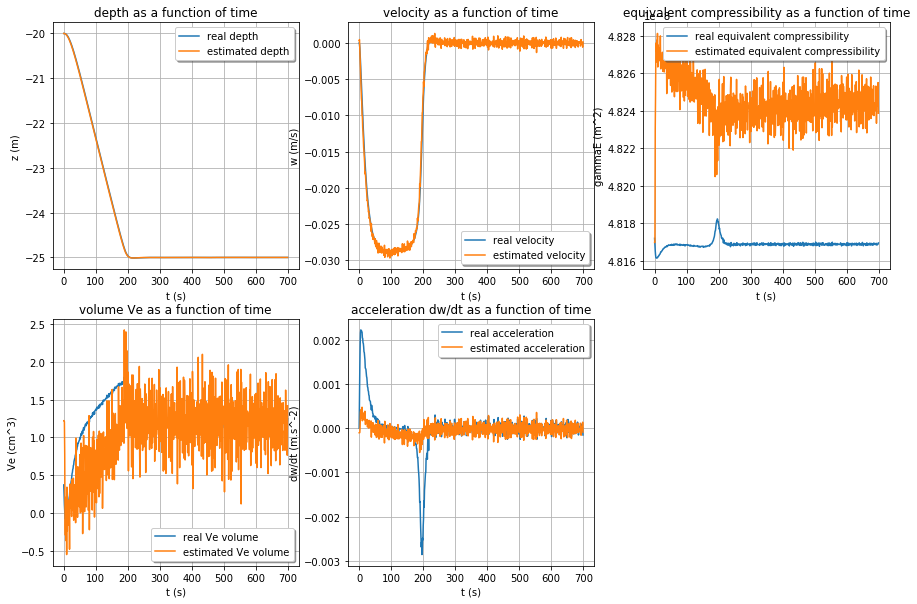

In [28]:
depth_rms = 1e-3 # m
vel_rms = depth_rms/dt # mm/s
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] )})
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

---

### Kalman filter parameters : gamma_alpha_gammaE variable

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f748a198>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


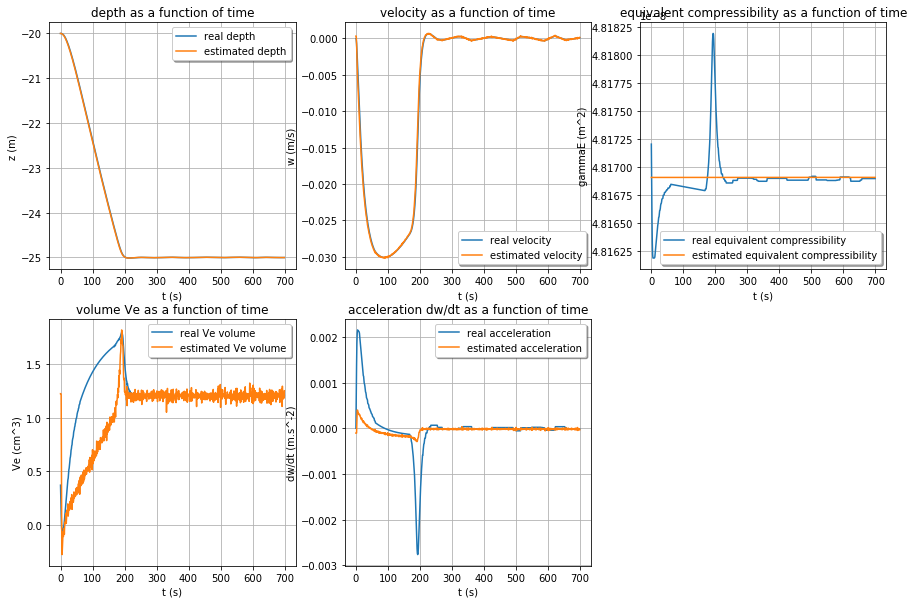

In [29]:
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
gamma_alpha_gammaE = 1e-10
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7fa8f56f1550>
 ctrl: mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


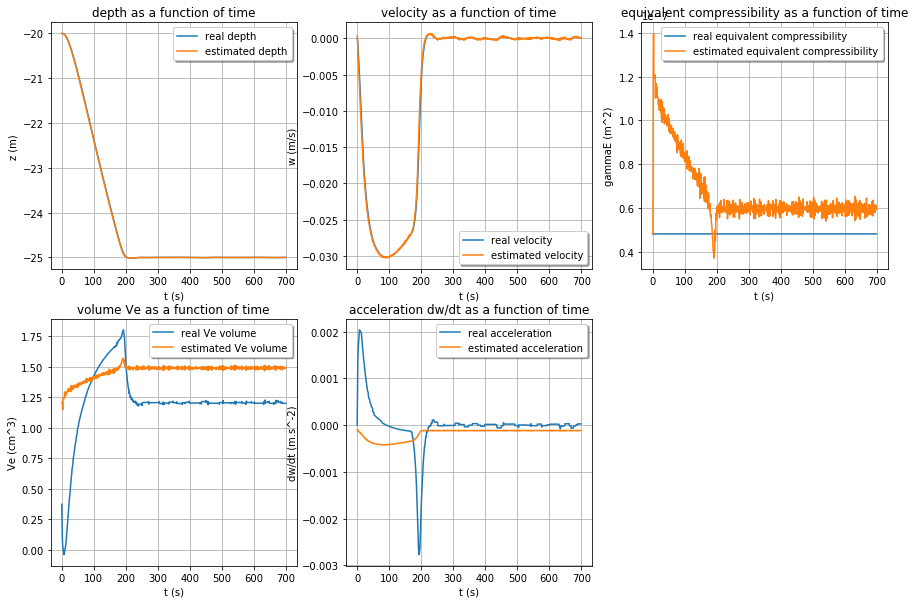

In [30]:
gamma_alpha_gammaE = 1e-6
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          #'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (dt*vel_rms)**2, (dt*gamma_alpha_gammaE)**2, (dt*Ve_rms)**2] )})
#
f.time_step(w,T=700., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f.log.t, f.log.gammaV*f.log.z)
ax.set_title("gammaV*z as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gammaV*z (m^3)")
ax.grid()

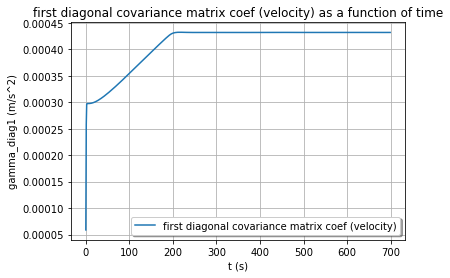

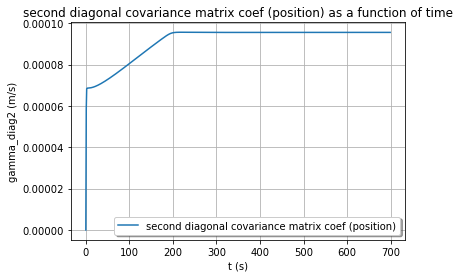

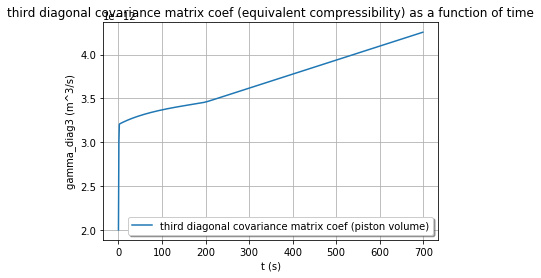

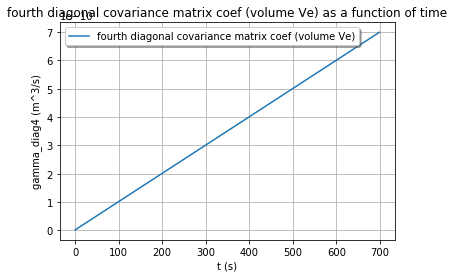

In [28]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag1, label ="first diagonal covariance matrix coef (velocity)")
ax.set_title("first diagonal covariance matrix coef (velocity) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag1 (m/s^2)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag2, label ="second diagonal covariance matrix coef (position)")
ax.set_title("second diagonal covariance matrix coef (position) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag2 (m/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag3, label ="third diagonal covariance matrix coef (piston volume)")
ax.set_title("third diagonal covariance matrix coef (equivalent compressibility) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag3 (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag4, label ="fourth diagonal covariance matrix coef (volume Ve)")
ax.set_title("fourth diagonal covariance matrix coef (volume Ve) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag4 (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

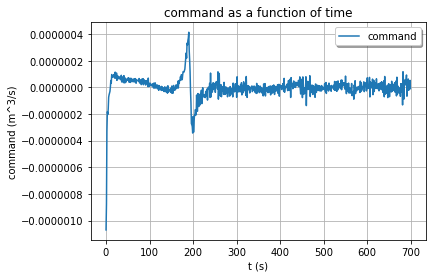

In [29]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.u, label ="command")
ax.set_title("command as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("command (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


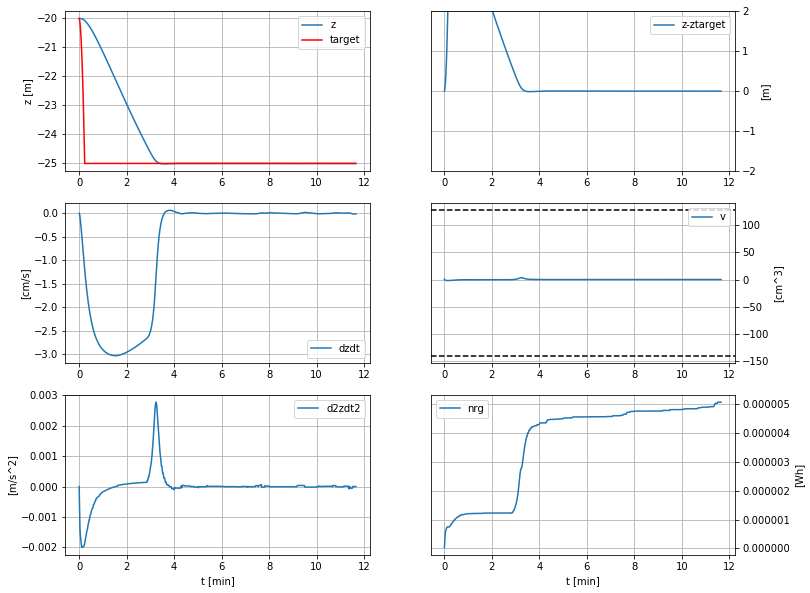

In [30]:
# plot log
z_target = z_target_variable
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [31]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [32]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7eff12f1d0f0>
 ctrl: mode = kalman_feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


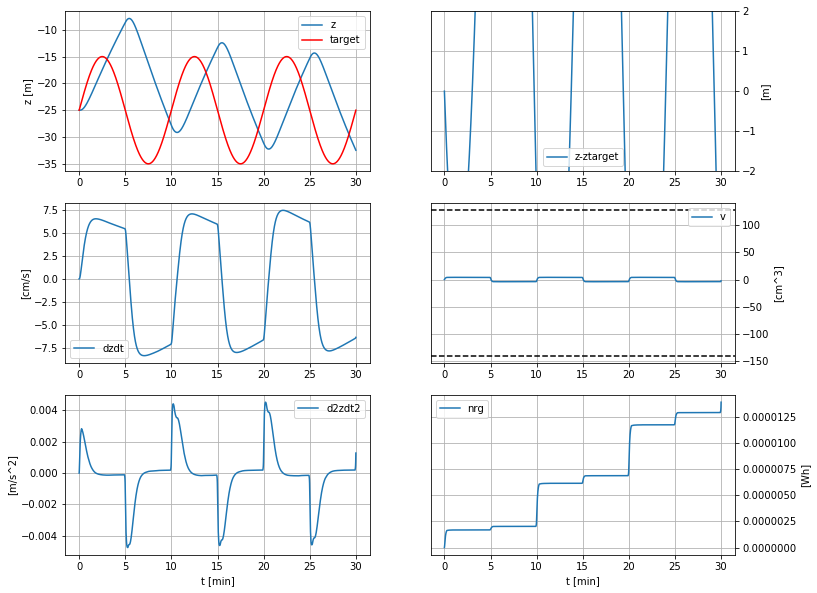

In [33]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [34]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [35]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 9.954764191606627
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.09954764191606627
 ctrl: kalman = <float_lib.Kalman object at 0x7eff12f1d0f0>
 ctrl: mode = kalman_feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


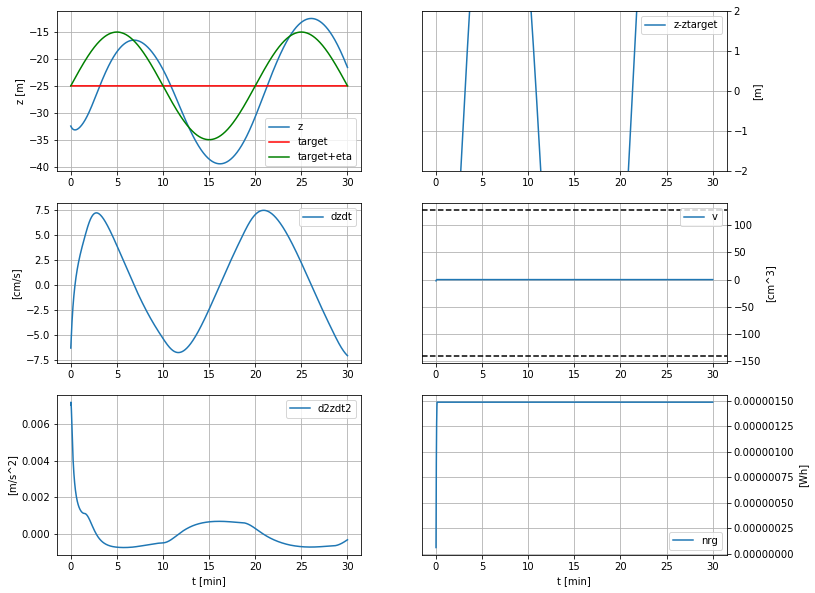

In [36]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [37]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


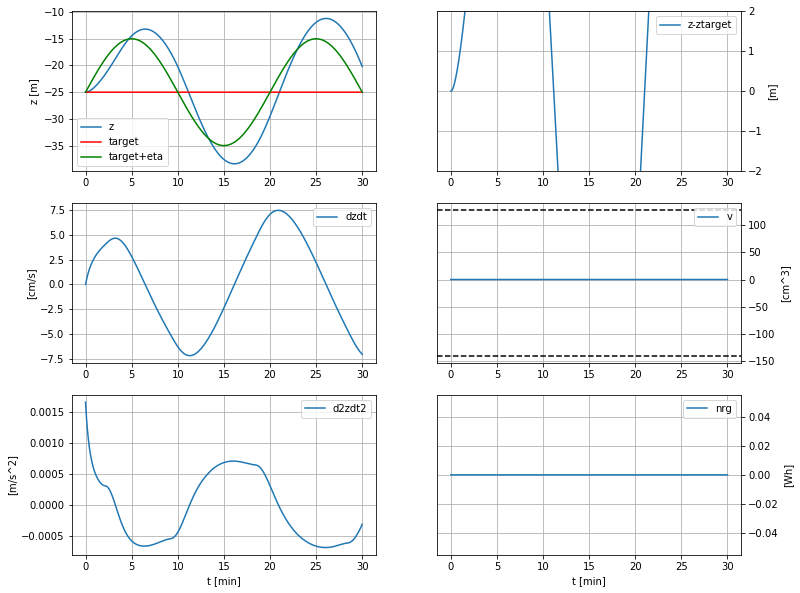

In [38]:
plot_log(f, z_target=z_target, eta=eta)